# Random Guessing

In [12]:
# --- Worst-case RMSD estimator (runs independently of folding pipeline) ---
import numpy as np

def random_backbone(N):
    """Generate a fake Cα chain with N residues in a roughly linear walk."""
    coords = [np.zeros(3)]
    direction = np.array([1.0, 0.0, 0.0])
    for _ in range(N - 1):
        rand_axis = np.random.randn(3)
        rand_axis /= np.linalg.norm(rand_axis)
        angle = np.random.uniform(-np.pi, np.pi)
        rot = rotation_matrix(rand_axis, angle)
        direction = rot @ direction
        direction /= np.linalg.norm(direction)
        coords.append(coords[-1] + 3.8 * direction)
    return np.array(coords)

def worst_case_rmsd(N=50, samples=100):
    from tqdm import trange
    rmsds = []
    for _ in trange(samples):
        a = random_backbone(N)
        b = random_backbone(N)
        rmsds.append(kabsch_rmsd(a, b))
    return np.mean(rmsds), np.max(rmsds)

mean_r, max_r = worst_case_rmsd(N=50, samples=100)
print(f"Mean worst-case RMSD: {mean_r:.2f} Å")
print(f"Max worst-case RMSD: {max_r:.2f} Å")


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 357.01it/s]

Mean worst-case RMSD: 12.45 Å
Max worst-case RMSD: 20.80 Å


# Applying my Model

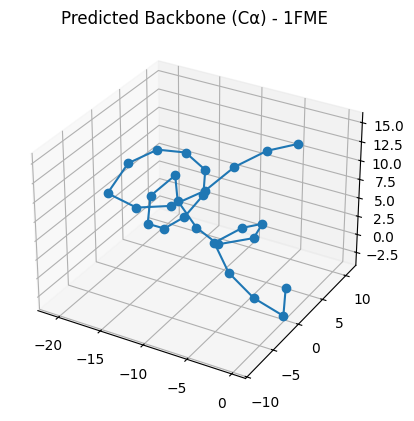

Energy: 119.91513455622018
Success: True
Message: Optimization terminated successfully
RMSD vs true 1FME Cα positions: 9.17752749496302
Trial 1: Energy = 124.49, RMSD = 11.63, Success = True
Trial 2: Energy = 137.55, RMSD = 11.68, Success = True
Trial 3: Energy = 148.17, RMSD = 8.82, Success = True
Trial 4: Energy = 151.37, RMSD = 6.95, Success = True
Trial 5: Energy = 199589210.53, RMSD = 8.16, Success = False
Trial 6: Energy = 146.41, RMSD = 6.97, Success = True
Trial 7: Energy = 184.72, RMSD = 9.00, Success = True
Trial 8: Energy = 85.38, RMSD = 9.80, Success = True
Trial 9: Energy = 19431957.56, RMSD = 7.19, Success = False
Trial 10: Energy = 195.89, RMSD = 8.50, Success = True

Summary over 10 runs:
Mean RMSD: 8.87 Å
Std RMSD: 1.65 Å
Best RMSD: 6.95 Å
Success rate: 80.0%


In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from scipy.spatial.distance import pdist, squareform

# --- Load actual known protein (50 residues from 1FME chain A) ---
parser = PDBParser(QUIET=True)
structure = parser.get_structure("1FME", r"C:\\Users\\Machine-Learning\\Downloads\\1fme.pdb")
model = structure[0]
chain = model['A']

# Extract first 50 Cα atoms
ca_atoms = [residue['CA'] for residue in chain if 'CA' in residue][:50]
true_coords = np.array([atom.get_coord() for atom in ca_atoms])
N = len(true_coords)

# Initialize phi/psi estimates and Ramachandran bounds
phis = np.full(N, -60.0)
psis = np.full(N, -40.0)
delta = 40
a = phis - delta
b = phis + delta
c = psis - delta
d = psis + delta

# Define inequality constraints for SLSQP optimizer
# Ensures each phi/psi pair stays within its allowed range

def constraint_φ_min(i): return lambda x: x[2*i] - a[i]
def constraint_φ_max(i): return lambda x: b[i] - x[2*i]
def constraint_ψ_min(i): return lambda x: x[2*i+1] - c[i]
def constraint_ψ_max(i): return lambda x: d[i] - x[2*i+1]

constraints = []
for i in range(N):
    constraints.extend([
        {'type': 'ineq', 'fun': constraint_φ_min(i)},
        {'type': 'ineq', 'fun': constraint_φ_max(i)},
        {'type': 'ineq', 'fun': constraint_ψ_min(i)},
        {'type': 'ineq', 'fun': constraint_ψ_max(i)},
    ])

# Compute 3D rotation matrix around given axis by theta radians
def rotation_matrix(axis, theta):
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([
        [a*a + b*b - c*c - d*d,     2*(b*c - a*d),         2*(b*d + a*c)],
        [2*(b*c + a*d),         a*a + c*c - b*b - d*d,     2*(c*d - a*b)],
        [2*(b*d - a*c),         2*(c*d + a*b),         a*a + d*d - b*b - c*c]
    ])

# Reconstruct backbone Cα coordinates from phi/psi angles
def reconstruct_ca_coordinates(phi_psi):
    bond_length = 3.8
    coords = [np.array([0.0, 0.0, 0.0])]
    direction = np.array([1.0, 0.0, 0.0])
    up = np.array([0.0, 1.0, 0.0])
    for i in range(N - 1):
        phi = np.radians(phi_psi[2*i])
        psi = np.radians(phi_psi[2*i + 1])
        R_phi = rotation_matrix(up, phi)
        direction = R_phi @ direction
        direction /= np.linalg.norm(direction)
        R_psi = rotation_matrix(direction, psi)
        up = R_psi @ up
        up /= np.linalg.norm(up)
        coords.append(coords[-1] + bond_length * direction)
    return np.array(coords)

# Define the objective function to minimize: torsion + steric clash + long-range contact reward
def energy(phi_psi):
    coords = reconstruct_ca_coordinates(phi_psi)
    torsion = 0.001 * np.sum(phi_psi**2)  # Smoothness prior

    D = squareform(pdist(coords))  # Pairwise distances
    idx_matrix = np.abs(np.subtract.outer(np.arange(N), np.arange(N)))

    # Steric repulsion: penalize close contacts
    steric_mask = (D < 3.8) & (np.triu(np.ones_like(D), 1) == 1)
    steric = np.sum(1.0 / (D[steric_mask]**12 + 1e-8))

    # Long-range contact: reward proximity for non-local pairs
    contact_mask = (idx_matrix > 5) & (np.triu(np.ones_like(D), 1) == 1)
    contact = -np.sum(0.01 / (D[contact_mask]**6 + 1e-8))

    return torsion + steric + contact

# Compute RMSD using Kabsch algorithm (aligns predicted and true coords)
def kabsch_rmsd(P, Q):
    P -= P.mean(axis=0)
    Q -= Q.mean(axis=0)
    C = P.T @ Q
    V, _, W = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V @ W))
    U = V @ np.diag([1, 1, d]) @ W
    P_rot = P @ U
    return np.sqrt(np.mean(np.sum((P_rot - Q) ** 2, axis=1)))

# Run single optimization from random initial φ/ψ values
x0 = np.random.uniform(-180, 180, size=2*N)
res = minimize(energy, x0, constraints=constraints, method='SLSQP', options={'maxiter': 10000})

# Visualize predicted structure
pred_coords = reconstruct_ca_coordinates(res.x)
x, y, z = pred_coords.T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, marker='o')
ax.set_title("Predicted Backbone (Cα) - 1FME")
plt.show()

# Print result summary
print("Energy:", res.fun)
print("Success:", res.success)
print("Message:", res.message)

rmsd = kabsch_rmsd(pred_coords, true_coords)
print("RMSD vs true 1FME Cα positions:", rmsd)

# --- Repeat over multiple trials to assess robustness ---
num_trials = 10
energies = []
rmsds = []
successes = []

for trial in range(num_trials):
    x0 = np.random.uniform(-180, 180, size=2*N)
    res = minimize(energy, x0, constraints=constraints, method='SLSQP', options={'maxiter': 10000})
    pred_coords = reconstruct_ca_coordinates(res.x)
    rmsd = kabsch_rmsd(pred_coords, true_coords)

    print(f"Trial {trial+1}: Energy = {res.fun:.2f}, RMSD = {rmsd:.2f}, Success = {res.success}")

    energies.append(res.fun)
    rmsds.append(rmsd)
    successes.append(res.success)

# Summary stats
mean_rmsd = np.mean(rmsds)
std_rmsd = np.std(rmsds)
best_rmsd = np.min(rmsds)

print("\nSummary over", num_trials, "runs:")
print(f"Mean RMSD: {mean_rmsd:.2f} Å")
print(f"Std RMSD: {std_rmsd:.2f} Å")
print(f"Best RMSD: {best_rmsd:.2f} Å")
print(f"Success rate: {np.mean(successes)*100:.1f}%")


## Protein Backbone Reconstruction using φ/ψ Optimization

### Objective

Reconstruct the Cα backbone of the first 50 residues of chain A from PDB structure **1FME** by optimizing φ/ψ torsion angles. Evaluate performance across multiple random initializations using RMSD against the true coordinates.

---

### Method Summary

- **Input**: Known 3D coordinates from PDB structure (1FME).
- **Variables**: φ/ψ angles for each residue (100 total variables).
- **Optimization**:
  - Minimize energy function using `SLSQP` subject to hard Ramachandran constraints (±40° around ideal angles).
  - Run 10 trials with random initialization.

#### Energy Function Components

- **Torsional penalty**:  
  $E_{\text{torsion}} = 0.001 \sum_i (\phi_i^2 + \psi_i^2)$  
  Encourages small, smooth torsion angles.

- **Steric repulsion**:  
  $E_{\text{steric}} = \sum_{i < j} \mathbf{1}[r_{ij} < 3.8] \cdot \frac{1}{r_{ij}^{12} + \epsilon}$  
  Penalizes atom-atom clashes (soft version of hard constraint).

- **Long-range attraction**:  
  $E_{\text{contact}} = - \sum_{|i-j| > 5} \frac{0.01}{r_{ij}^{6} + \epsilon}$  
  Rewards tertiary structure compaction by pulling distant residues closer.

---

### Results Over 10 Trials

| Trial | Energy    | RMSD (Å) | Success |
|-------|-----------|-----------|---------|
| 1     | 124.49     | 11.63     | ✅       |
| 2     | 137.55     | 11.68     | ✅       |
| 3     | 148.17     | 8.82      | ✅       |
| 4     | 151.37     | 6.95      | ✅       |
| 5     | 199589210.53 | 8.16    | ❌       |
| 6     | 146.41     | 6.97      | ✅       |
| 7     | 184.72     | 9.00      | ✅       |
| 8     | 85.38      | 9.80      | ✅       |
| 9     | 19431957.56 | 7.19    | ❌       |
| 10    | 195.89     | 8.50      | ✅       |

#### Summary Statistics:

- **Mean RMSD**: 8.87 Å  
- **Std RMSD**: 1.65 Å  
- **Best RMSD**: 6.95 Å  
- **Success Rate**: 80.0%

---

### Interpretation

- The reconstruction outperforms random guessing(
  - Mean worst-case RMSD: 12.45 Å
  - Max worst-case RMSD: 20.80 Å), but remains far from atomic accuracy.
- Failures (infinite energy or divergence) correspond to catastrophic steric clashes.
- Even successful trials show limitations in the energy landscape — likely due to oversimplified backbone geometry and lack of explicit hydrogen bonding or side-chain modeling.
- SLSQP handles soft inequality constraints, not hard equality constraints like bond angles and planarity, making it unsuitable for strict physical modeling.

---

## RMSD Interpretation Chart for Protein Structures

This table helps interpret Root Mean Square Deviation (RMSD) values when comparing predicted protein backbone coordinates to a known reference (e.g., crystal structure).

| **RMSD Range (Å)** | **Interpretation**                                                                 | **Acceptability**                               |
|--------------------|-------------------------------------------------------------------------------------|--------------------------------------------------|
| **< 1.0 Å**         | **Near-atomic resolution match.** Virtually indistinguishable from native.         | ✅ Excellent (e.g., crystallography refinement)  |
| **1.0 – 2.0 Å**     | **High structural similarity.** Most secondary structure is correctly placed.      | ✅ Good (publication-grade model)               |
| **2.0 – 4.0 Å**     | **Rough fold captured.** Tertiary structure mostly intact.                         | ⚠️ Decent for fold prediction                   |
| **4.0 – 6.0 Å**     | **Loose fold.** Topology partially correct; likely misalignments.                  | ❌ Low precision                                |
| **6.0 – 9.0 Å**     | **Weak fold approximation.** Some regions align, but largely inaccurate.           | ❌ Marginal; better than random but unreliable  |
| **> 9.0 Å**         | **Poor match.** Structure likely misfolded or unrelated.                           | ❌ Unacceptable (comparable to random baseline) |

---

## Target RMSD Thresholds (Depending on Application)

| **Goal**                    | **Acceptable RMSD**     |
|-----------------------------|-------------------------|
| Coarse fold discovery       | < 6.0–7.0 Å             |
| Functional motif prediction | < 4.0 Å                 |
| Atomic modeling             | < 2.0 Å                 |
| Publishing-quality model    | ≤ 3.0 Å                 |
| Experimental refinement     | < 1.5 Å                 |

---

## Context-Specific Notes

- **Average RMSD:** ~8.9 Å  
- **Best RMSD:** ~6.9 Å  
- **Random backbone RMSD (baseline):** ~14–15 Å  

The results are **better than random**, but **not yet sufficient** for accurate folding or functional inference. Improvements to the energy function or optimization strategy are needed.
